In [1]:
import os
import torch
import numpy as np 
import pandas as pd 
from torch import nn
from torch.autograd import Variable

import torchvision.transforms as tfs
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    x = tfs.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 54582288.52it/s]


Extracting /kaggle/working/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1538465.47it/s]


Extracting /kaggle/working/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13920287.98it/s]


Extracting /kaggle/working/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3672745.09it/s]


Extracting /kaggle/working/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/mnist/MNIST/raw



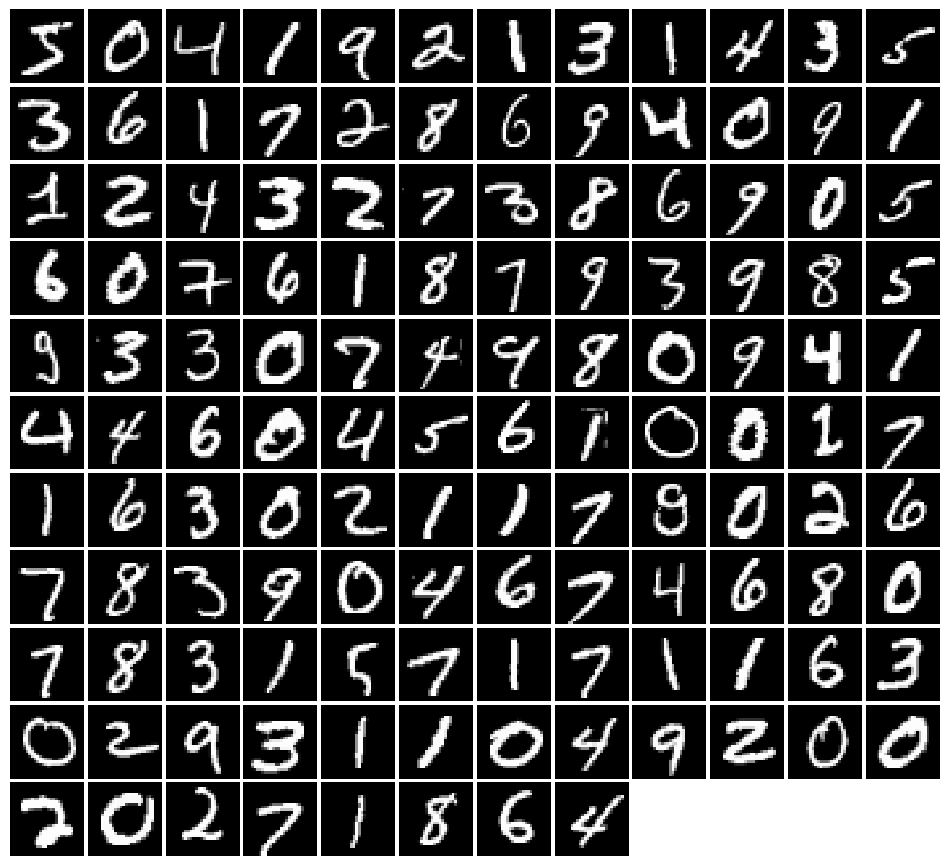

In [2]:
class ChunkSampler(sampler.Sampler): # 定义一个取样的函数
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

train_set = MNIST('/kaggle/working/mnist', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0))

val_set = MNIST('/kaggle/working/mnist', train=True, download=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = deprocess_img(next(iter(train_data))[0].view(batch_size, 784)).numpy().squeeze() # 可视化图片效果
show_images(imgs)

In [3]:
# 卷积判别网络
class build_dc_classifier(nn.Module):
    def __init__(self):
        super(build_dc_classifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),    # (bs,32,23,23)
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),        # (bs,32,12,12)
            nn.Conv2d(32, 64, 5, 1),   # (bs,64,7,7)
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)         # (bs,64,4,4)
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),     
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x



In [4]:
# 卷积生成网络
class build_dc_generator(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(build_dc_generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape 通道是 128，大小是 7x7
        x = self.conv(x)
        return x



In [5]:
bce_loss = nn.BCEWithLogitsLoss()

def discriminator_loss(logits_real, logits_fake): # 判别器的 loss
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    false_labels = Variable(torch.zeros(size, 1)).float().cuda()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss

In [6]:
def generator_loss(logits_fake): # 生成器的 loss  
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float().cuda()
    loss = bce_loss(logits_fake, true_labels)
    return loss

In [7]:
# 使用 adam 来进行训练，学习率是 3e-4, beta1 是 0.5, beta2 是 0.999
def get_optimizer(net):
    optimizer = torch.optim.Adam(net.parameters(), lr=3e-4, betas=(0.5, 0.999))
    return optimizer

In [8]:
def train_dc_gan(D_net, G_net, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # 判别网络
            real_data = Variable(x).cuda() # 真实数据
            logits_real = D_net(real_data) # 判别网络得分

            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据
            logits_fake = D_net(fake_images) # 判别网络得分

            d_total_error = discriminator_loss(logits_real, logits_fake) # 判别器的 loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # 优化判别网络

            # 生成网络
            g_fake_seed = Variable(sample_noise).cuda()
            fake_images = G_net(g_fake_seed) # 生成的假的数据

            gen_logits_fake = D_net(fake_images)
            g_error = generator_loss(gen_logits_fake) # 生成网络的 loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # 优化生成网络

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.item(), g_error.item()))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
                if not os.path.exists('./GAN_Conv_img'):
                    os.makedirs('./GAN_Conv_img')
                save_image(deprocess_img(fake_images[0:16].cpu().data), f'./GAN_Conv_img/img_{iter_count}.png')
            iter_count += 1


Iter: 0, D: 1.388, G:0.9527


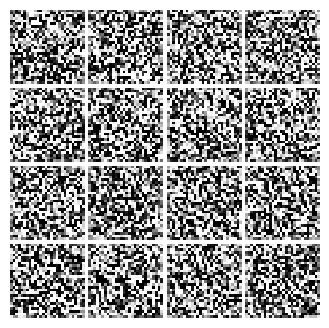


Iter: 250, D: 1.117, G:3.746


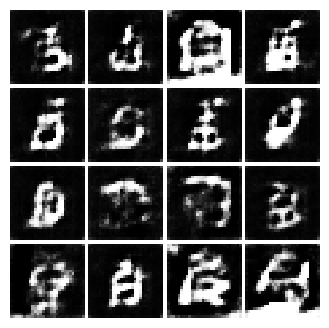


Iter: 500, D: 0.9479, G:1.046


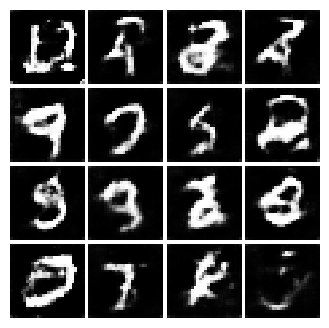


Iter: 750, D: 1.326, G:0.3404


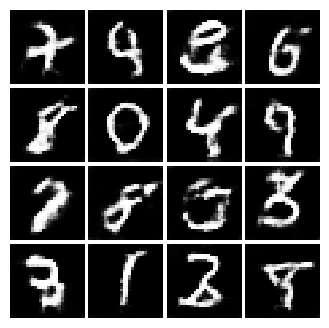


Iter: 1000, D: 1.221, G:1.145


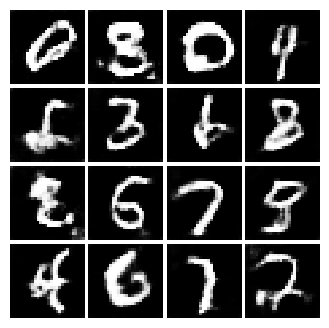


Iter: 1250, D: 0.9912, G:0.945


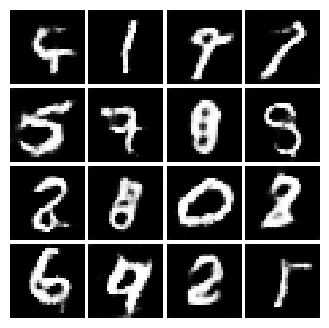


Iter: 1500, D: 0.9937, G:1.094


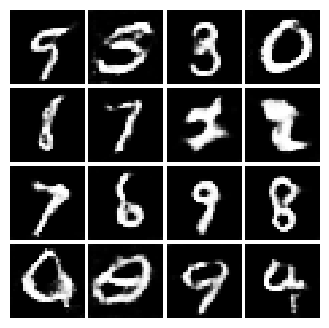


Iter: 1750, D: 1.082, G:1.676


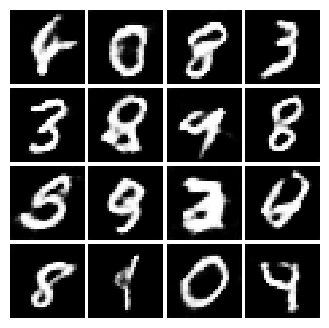


Iter: 2000, D: 0.949, G:1.246


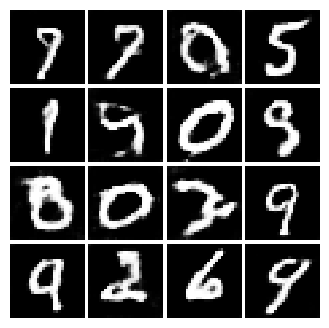


Iter: 2250, D: 1.044, G:1.737


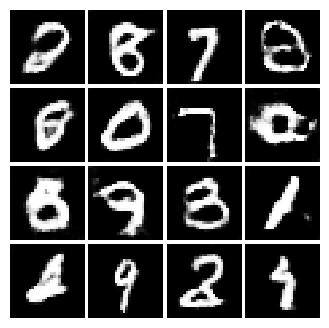


Iter: 2500, D: 1.027, G:1.172


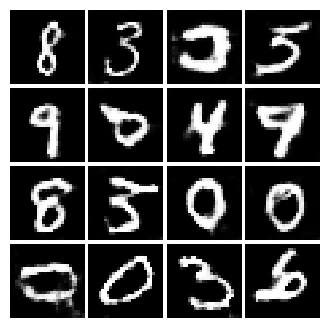


Iter: 2750, D: 1.171, G:0.887


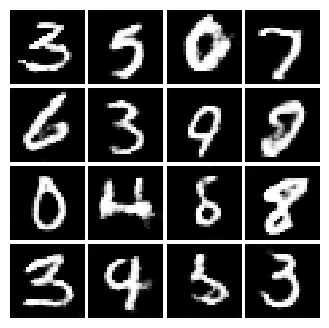


Iter: 3000, D: 1.328, G:0.9218


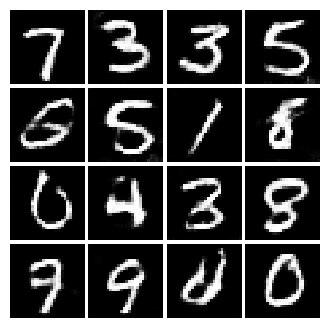


Iter: 3250, D: 0.9445, G:1.225


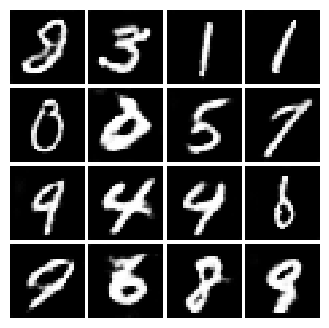


Iter: 3500, D: 1.113, G:1.269


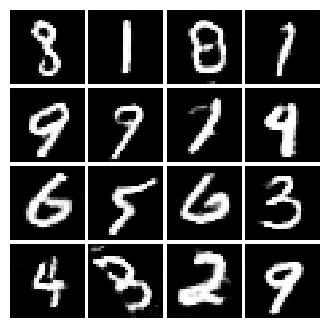


Iter: 3750, D: 0.9593, G:1.405


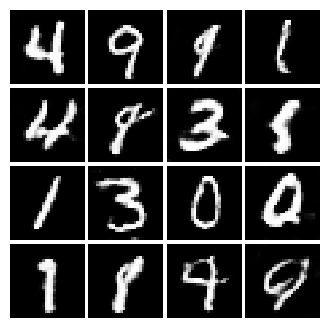


Iter: 4000, D: 1.09, G:1.119


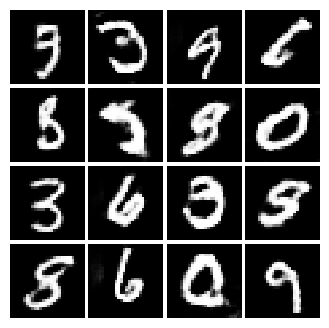


Iter: 4250, D: 1.015, G:1.569


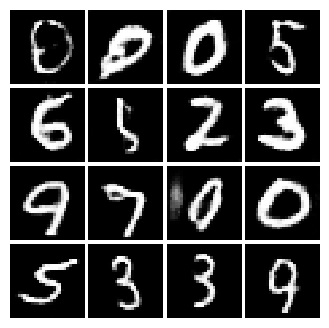


Iter: 4500, D: 1.022, G:1.191


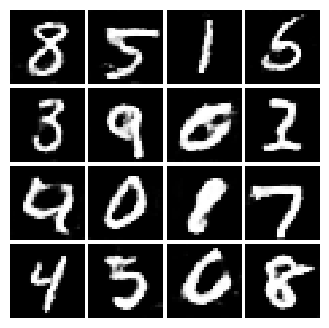


Iter: 4750, D: 1.107, G:1.083


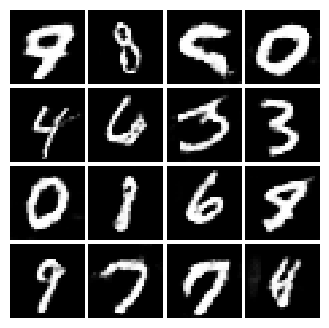


Iter: 5000, D: 1.042, G:1.512


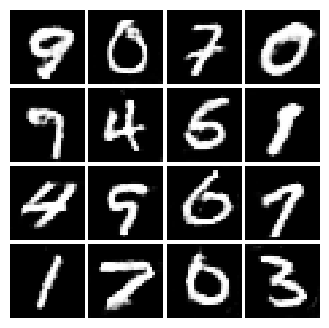


Iter: 5250, D: 1.045, G:1.978


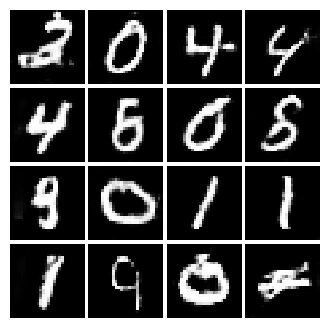


Iter: 5500, D: 0.9782, G:1.686


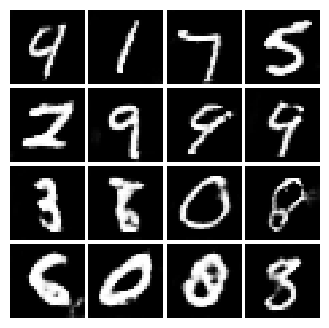


Iter: 5750, D: 0.9695, G:1.319


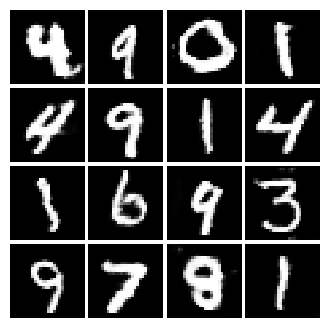


Iter: 6000, D: 1.043, G:1.025


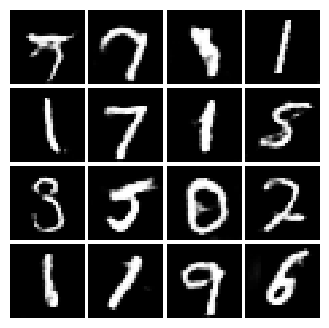


Iter: 6250, D: 1.119, G:1.135


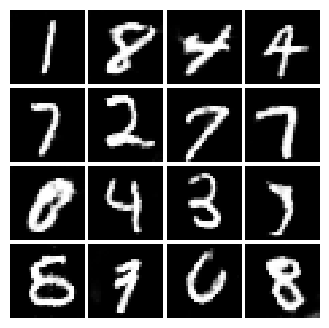


Iter: 6500, D: 1.03, G:1.024


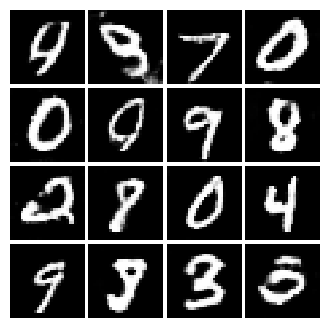


Iter: 6750, D: 0.9882, G:1.4


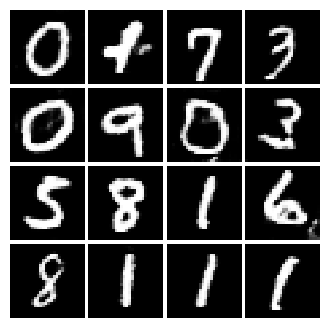


Iter: 7000, D: 0.9924, G:1.295


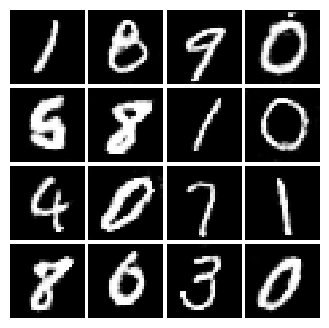


Iter: 7250, D: 1.019, G:1.316


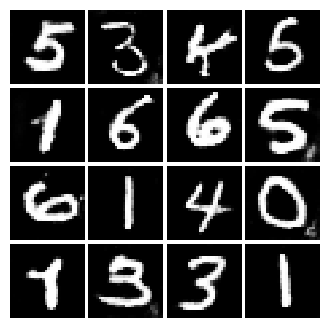


Iter: 7500, D: 1.001, G:1.127


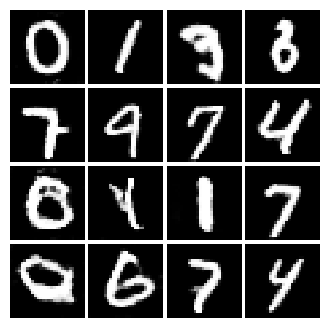


Iter: 7750, D: 1.512, G:0.9193


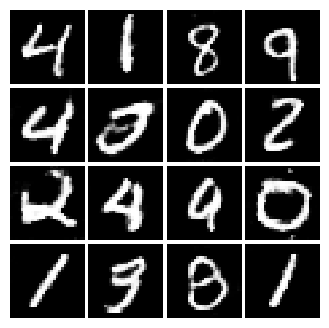

In [9]:
D_DC = build_dc_classifier().cuda()
G_DC = build_dc_generator().cuda()

D_DC_optim = get_optimizer(D_DC)
G_DC_optim = get_optimizer(G_DC)

train_dc_gan(D_DC, G_DC, D_DC_optim, G_DC_optim, discriminator_loss, generator_loss, num_epochs=20)

